# Jailbreaking Deep Models – Project Notebook
This notebook covers **Task 1 – Task 5** in the project description, and provides complete reproducible code and necessary instructions. Before running, make sure you have:

1. Unzip `TestDataSet.zip` to `data/TestDataSet/`.

2. Put `imagenet_class_index.json` in the same directory.(From https://github.com/raghakot/keras-vis/blob/master/resources/imagenet_class_index.json)

3. `pip install torch torchvision matplotlib tqdm` and other dependencies.
---

In [1]:
!unzip TestDataSet.zip -d data

Archive:  TestDataSet.zip
   creating: data/TestDataSet/
   creating: data/TestDataSet/n02795169/
  inflating: data/__MACOSX/TestDataSet/._n02795169  
   creating: data/TestDataSet/n02769748/
  inflating: data/__MACOSX/TestDataSet/._n02769748  
   creating: data/TestDataSet/n02834397/
  inflating: data/__MACOSX/TestDataSet/._n02834397  
   creating: data/TestDataSet/n02917067/
  inflating: data/__MACOSX/TestDataSet/._n02917067  
   creating: data/TestDataSet/n02808304/
  inflating: data/__MACOSX/TestDataSet/._n02808304  
   creating: data/TestDataSet/n03016953/
  inflating: data/__MACOSX/TestDataSet/._n03016953  
   creating: data/TestDataSet/n02793495/
  inflating: data/__MACOSX/TestDataSet/._n02793495  
   creating: data/TestDataSet/n02814533/
  inflating: data/__MACOSX/TestDataSet/._n02814533  
   creating: data/TestDataSet/n02837789/
  inflating: data/__MACOSX/TestDataSet/._n02837789  
   creating: data/TestDataSet/n02840245/
  inflating: data/__MACOSX/TestDataSet/._n02840245  
   

In [2]:
# Import necessary libraries
import os, json, random, math, shutil, time, itertools
from pathlib import Path

import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms, utils
from torchvision.datasets import ImageFolder

from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [3]:
# Data paths & constants
DATA_ROOT = Path('data/TestDataSet') # Define the root directory for the test dataset
CLASS_IDX_FILE = Path('imagenet_class_index.json') # Path to the ImageNet class index file
RESULTS_DIR = Path('results') # Directory to store the results

# Create the results directory if it doesn't already exist
RESULTS_DIR.mkdir(exist_ok=True)

# Retain the original numpy arrays for normalization
mean_norms = np.array([0.485, 0.456, 0.406])
std_norms  = np.array([0.229, 0.224, 0.225])

# Create Torch tensors and explicitly set dtype=float32
mean_t = torch.tensor(mean_norms, device=device, dtype=torch.float32).view(3,1,1)
std_t  = torch.tensor(std_norms,  device=device, dtype=torch.float32).view(3,1,1)

# Calculate the lower and upper bounds for normalization
LOWER = (-mean_t) / std_t # Lower bound after normalization
UPPER = (1 - mean_t) / std_t # Upper bound after normalization

# Define image transformation pipeline
plain_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_norms, std=std_norms)
])

# Load the ImageNet class index mapping from a JSON file
with open(CLASS_IDX_FILE) as f:
    idx_to_synset = json.load(f)          # {"0": ["n01440764", "tench"], ...}
synset_to_idx = {v[0]: int(k) for k, v in idx_to_synset.items()}

# Load the dataset using ImageFolder with the defined transformations
test_dataset = ImageFolder(root=str(DATA_ROOT), transform=plain_transforms)
# Create a DataLoader for the test dataset
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

print('Test images:', len(test_dataset))# number of test images in the dataset


Test images: 500


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [4]:
# Evaluate the top-1 and top-5 accuracy of a neural network model on a given dataset (loaded via DataLoader)
def evaluate(model, loader, folder_classes):
    model.eval()
    top1 = top5 = total = 0
    with torch.no_grad():
        for imgs, folder_targets in tqdm(loader, desc="Evaluating", leave=False):
            imgs = imgs.to(device, non_blocking=True)

            # Map folder targets (ImageFolder) to ImageNet 0-999 indices
            folder_names = [folder_classes[t] for t in folder_targets]
            true_indices = torch.tensor(
                [synset_to_idx[s] for s in folder_names], device=device
            )

            logits = model(imgs)
            top5_idx = logits.topk(5, dim=1).indices # [B,5]

            # Top-1 accuracy: Check if the highest scoring class matches the true label
            top1 += (top5_idx[:, 0] == true_indices).sum().item()
            # Top-5 accuracy: Check if any of the top 5 predictions match the true label
            top5 += (top5_idx == true_indices.unsqueeze(1)).any(dim=1).sum().item()

            total += imgs.size(0)

    return top1 / total * 100, top5 / total * 100

def imshow(tensor, title=None):
    # tensor: normalized
    img = tensor.cpu().clone()
    img = img * torch.tensor(std_norms).view(3,1,1) + torch.tensor(mean_norms).view(3,1,1) # Denormalization
    img = img.clamp(0,1)
    plt.imshow(img.permute(1,2,0)) # Use permute(1,2,0) to convert the image tensor from (C,H,W) to (H,W,C) to suit the matplotlib display format.
    if title: plt.title(title)
    plt.axis('off')


In [5]:
# Task 1 : Baseline evaluation
model = torchvision.models.resnet34(weights='IMAGENET1K_V1').to(device)
model.eval()

baseline_top1, baseline_top5 = evaluate(model, test_loader, test_dataset.classes)


print(f"Baseline Top‑1: {baseline_top1:.2f}% | Top‑5: {baseline_top5:.2f}%")


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 190MB/s]
                                                           

Baseline Top‑1: 76.00% | Top‑5: 94.20%


In [6]:
# Task 2 : FGSM pixel‑wise attack
EPSILON = 0.02

def fgsm_attack(model, loader, epsilon, out_dir):
    model.eval()
    atk_dir = RESULTS_DIR/out_dir
    if atk_dir.exists(): shutil.rmtree(atk_dir)
    atk_dir.mkdir(parents=True)
    success = 0
    total = 0
    new_images = []

    for imgs, labels in tqdm(loader, desc='FGSM'):
        imgs, labels = imgs.to(device), labels.to(device)

        # -- Index directory → ImageNet 0-999 --
        folder_names = [loader.dataset.classes[t] for t in labels]
        true_idx     = torch.tensor([synset_to_idx[s] for s in folder_names],
                                    device=device)
        imgs.requires_grad = True
        outputs = model(imgs)
        loss = F.cross_entropy(outputs, true_idx)
        model.zero_grad()
        loss.backward()
        data_grad = imgs.grad.data
        sign_data_grad = data_grad.sign()
        perturbed_image = imgs + epsilon * sign_data_grad
        perturbed_image = torch.clamp(perturbed_image, LOWER, UPPER)

        for i in range(perturbed_image.size(0)):
            # Get the original synset directory name (such as 'n01440764')
            folder_name = loader.dataset.classes[labels[i].item()]

            # Target directory: results/adv_setX_xxx/<synset>/
            cls_dir = atk_dir / folder_name
            cls_dir.mkdir(parents=True, exist_ok=True)

            # File name: Keep it unique
            save_path = cls_dir / f"{total+i:05d}.png"

            adv = perturbed_image[i].detach().cpu()
            img_dn = adv * std_t.cpu() + mean_t.cpu()
            img_dn = (img_dn * 255).clamp(0, 255).byte().permute(1, 2, 0).numpy()
            Image.fromarray(img_dn).save(save_path)
        total += imgs.size(0)

        # Track attack success
        preds = model(perturbed_image).argmax(1)
        success += (preds != true_idx).sum().item()

    print(f"FGSM attack success rate: {success/len(loader.dataset)*100:.2f}%")
    return atk_dir

adv1_dir = fgsm_attack(model, test_loader, EPSILON, 'adv_set1_fgsm')


FGSM: 100%|██████████| 16/16 [00:13<00:00,  1.14it/s]

FGSM attack success rate: 93.80%


In [7]:
# Reload the adversarial dataset just saved
adv_dataset1 = ImageFolder(root=str(adv1_dir.parent/'adv_set1_fgsm'),
                           transform=plain_transforms)
adv_loader1  = DataLoader(adv_dataset1, batch_size=32, shuffle=False, num_workers=4)

fgsm_top1, fgsm_top5 = evaluate(model, adv_loader1, adv_dataset1.classes)
print(f"FGSM Top‑1: {fgsm_top1:.2f}% | Top‑5: {fgsm_top5:.2f}% (Δ {baseline_top1 - fgsm_top1:.2f}%, Δ {baseline_top5 - fgsm_top5:.2f}%)")


FGSM Top‑1: 4.40% | Top‑5: 31.20% (Δ 71.60%, Δ 63.00%)


In [8]:
# task 3 : Improved attack (PGD)
def pgd_attack(model, loader, epsilon=0.02, alpha=0.005, iters=10,
               out_dir='adv_set2_pgd'):
    model.eval()
    atk_dir = RESULTS_DIR / out_dir
    if atk_dir.exists():
        shutil.rmtree(atk_dir)
    atk_dir.mkdir(parents=True)

    total = success = 0

    for imgs, folder_targets in tqdm(loader, desc='PGD'):
        imgs = imgs.to(device, non_blocking=True)

        # -- Index directory → ImageNet 0-999 --
        folder_names = [loader.dataset.classes[t] for t in folder_targets]
        true_idx     = torch.tensor([synset_to_idx[s] for s in folder_names],
                                    device=device)

        ori  = imgs.clone().detach()
        pert = imgs.clone().detach().requires_grad_(True)

        for _ in range(iters):
            outputs = model(pert)
            loss    = F.cross_entropy(outputs, true_idx)
            model.zero_grad()
            loss.backward()

            grad = pert.grad.data.sign()
            pert = pert + alpha * grad
            pert = torch.max(torch.min(pert, ori + epsilon), ori - epsilon)
            pert = torch.clamp(pert, LOWER, UPPER).detach().requires_grad_(True)

        # Save adversarial samples and keep the synset directory
        for i in range(pert.size(0)):
            syn = folder_names[i]
            cls_dir = atk_dir / syn
            cls_dir.mkdir(parents=True, exist_ok=True)

            save_path = cls_dir / f"{total+i:05d}.png"
            adv = pert[i].cpu()
            img_dn = adv * std_t.cpu() + mean_t.cpu()
            img_dn = (img_dn * 255).clamp(0, 255).byte().permute(1,2,0).numpy()
            Image.fromarray(img_dn).save(save_path)
        total += imgs.size(0)

        # Statistics of attack success rate
        preds   = model(pert).argmax(1)
        success += (preds != true_idx).sum().item()

    print(f"PGD attack success rate: {success / total * 100:.2f}%")
    return atk_dir


# Use PGD to attack and load the adversarial dataset just saved to observe the impact on accuracy
adv2_dir      = pgd_attack(model, test_loader, epsilon=0.02,
                           alpha=0.004, iters=7)
adv_dataset2  = ImageFolder(str(adv2_dir), transform=plain_transforms)
adv_loader2   = DataLoader(adv_dataset2, batch_size=32, shuffle=False,
                           num_workers=4)

pgd_top1, pgd_top5 = evaluate(model, adv_loader2, adv_dataset2.classes)
print(f"PGD Top-1: {pgd_top1:.2f}% | Top-5: {pgd_top5:.2f}% "
      f"(Δ {baseline_top1 - pgd_top1:.2f}%, Δ {baseline_top5 - pgd_top5:.2f}%)")


PGD: 100%|██████████| 16/16 [00:28<00:00,  1.75s/it]


PGD attack success rate: 99.80%


PGD Top-1: 0.00% | Top-5: 9.20% (Δ 76.00%, Δ 85.00%)


In [9]:
# Task 4 : Local patch attack
def random_patch_attack(model, loader, patch_size=32, epsilon=0.5,
                        iters=15, alpha=0.05, out_dir='adv_set3_patch'):
    model.eval()
    atk_dir = RESULTS_DIR / out_dir
    if atk_dir.exists():
        shutil.rmtree(atk_dir)
    atk_dir.mkdir(parents=True)

    total = success = 0

    for imgs, folder_targets in tqdm(loader, desc='Patch attack'):
        imgs = imgs.to(device, non_blocking=True)

        # -- Index directory → ImageNet 0-999 --
        folder_names = [loader.dataset.classes[t] for t in folder_targets]
        true_idx     = torch.tensor([synset_to_idx[s] for s in folder_names],
                                    device=device)

        ori  = imgs.clone().detach()

        # Randomly generate uniform patch positions for the same batch
        _, _, H, W = imgs.shape
        top  = torch.randint(0, H - patch_size, (1,)).item() # The upper boundary of the patch area
        left = torch.randint(0, W - patch_size, (1,)).item() # Left border of the patch area
        mask = torch.zeros_like(imgs)
        mask[:, :, top:top+patch_size, left:left+patch_size] = 1 # The shape is the same as the input image, with the patch area set to 1 and the rest of the area set to 0.

        pert = imgs.clone().detach().requires_grad_(True)

        for _ in range(iters):
            outputs = model(pert)
            loss    = F.cross_entropy(outputs, true_idx)
            model.zero_grad()
            loss.backward()

            grad = pert.grad.data.sign()
            pert = pert + alpha * grad * mask # Update patch area only
            pert = torch.max(torch.min(pert, ori + epsilon*mask),
                             ori - epsilon*mask)
            pert = torch.clamp(pert, LOWER, UPPER).detach().requires_grad_(True)

        # Saving adversarial examples
        for i in range(pert.size(0)):
            syn = folder_names[i]
            cls_dir = atk_dir / syn
            cls_dir.mkdir(parents=True, exist_ok=True)

            save_path = cls_dir / f"{total+i:05d}.png"
            adv = pert[i].cpu()
            img_dn = adv * std_t.cpu() + mean_t.cpu()
            img_dn = (img_dn * 255).clamp(0, 255).byte().permute(1,2,0).numpy()
            Image.fromarray(img_dn).save(save_path)
        total += imgs.size(0)

        preds   = model(pert).argmax(1)
        success += (preds != true_idx).sum().item()

    print(f"Patch attack success rate: {success / total * 100:.2f}%")
    return atk_dir


# Use patch attack and load the adversarial dataset just saved to observe the impact on accuracy
adv3_dir      = random_patch_attack(model, test_loader, patch_size=32,
                                    epsilon=0.5, iters=15, alpha=0.05)
adv_dataset3  = ImageFolder(str(adv3_dir), transform=plain_transforms)
adv_loader3   = DataLoader(adv_dataset3, batch_size=32, shuffle=False,
                           num_workers=4)

patch_top1, patch_top5 = evaluate(model, adv_loader3, adv_dataset3.classes)
print(f"Patch Top-1: {patch_top1:.2f}% | Top-5: {patch_top5:.2f}% "
      f"(Δ {baseline_top1 - patch_top1:.2f}%, Δ {baseline_top5 - patch_top5:.2f}%)")


Patch attack: 100%|██████████| 16/16 [00:44<00:00,  2.75s/it]


Patch attack success rate: 62.60%


Patch Top-1: 37.40% | Top-5: 76.00% (Δ 38.60%, Δ 18.20%)


In [10]:
# Task 5 : Transferability
transfer_model = torchvision.models.densenet121(
    weights='IMAGENET1K_V1').to(device)
transfer_model.eval()

# Evaluate on different datasets
orig_top1, orig_top5 = evaluate(transfer_model, test_loader,
                                test_dataset.classes)

adv1_t1, adv1_t5 = evaluate(transfer_model, adv_loader1,
                            adv_dataset1.classes)

adv2_t1, adv2_t5 = evaluate(transfer_model, adv_loader2,
                            adv_dataset2.classes)

adv3_t1, adv3_t5 = evaluate(transfer_model, adv_loader3,
                            adv_dataset3.classes)

# Result summary table
import pandas as pd
table = pd.DataFrame({
    'Dataset':  ['Original', 'AdvSet1-FGSM', 'AdvSet2-PGD', 'AdvSet3-Patch'],
    'Top-1 (%)':[orig_top1,  adv1_t1,       adv2_t1,       adv3_t1],
    'Top-5 (%)':[orig_top5,  adv1_t5,       adv2_t5,       adv3_t5]
})

print(table.to_string(index=False))


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 163MB/s]


      Dataset  Top-1 (%)  Top-5 (%)
     Original       74.8       93.6
 AdvSet1-FGSM       60.8       86.8
  AdvSet2-PGD       61.8       89.4
AdvSet3-Patch       72.0       92.2


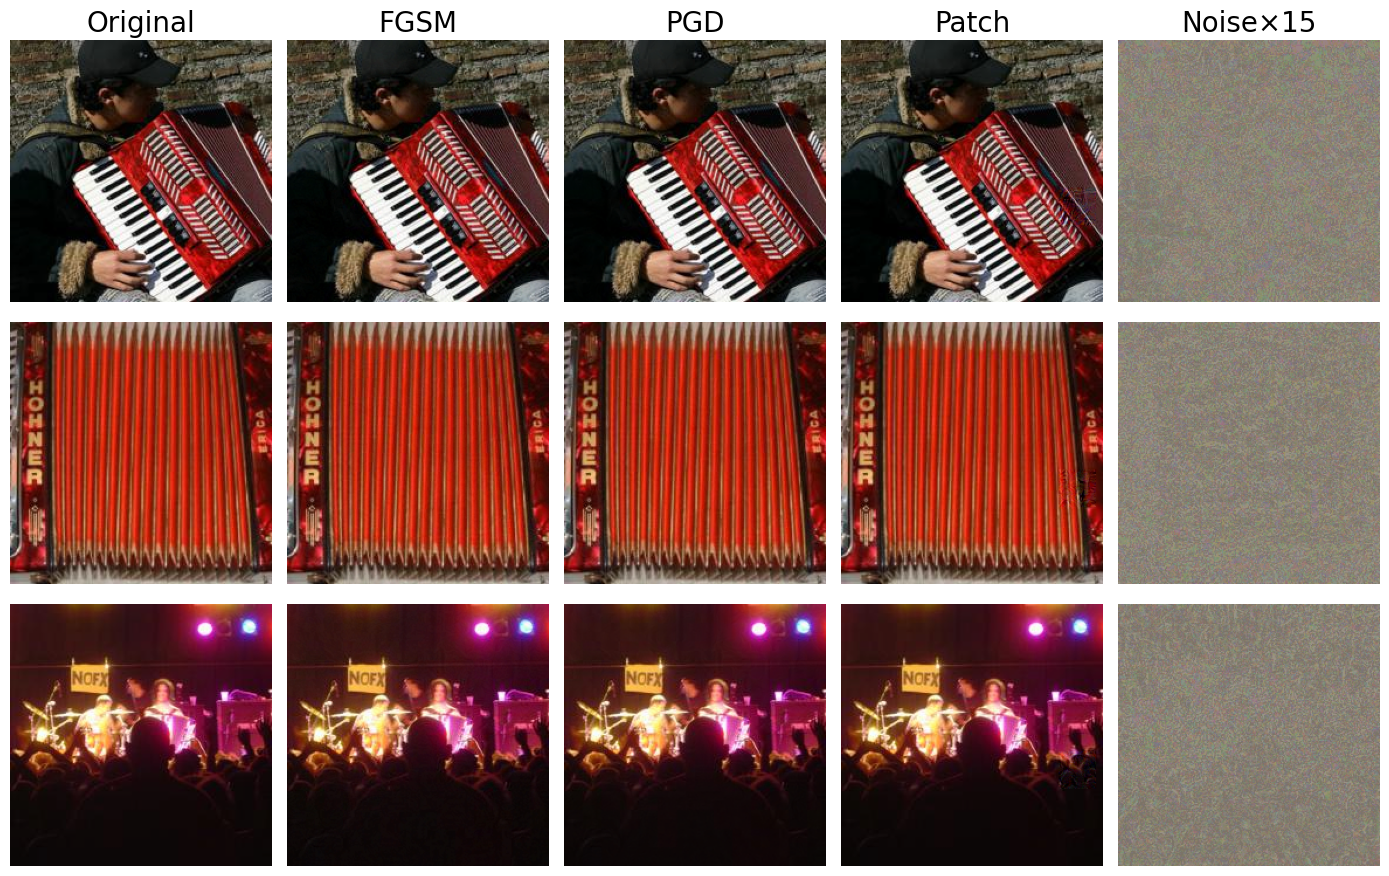

In [11]:
# Visualization example (with amplified noise)
k = 3                              # Take the first k examples
datasets = [test_dataset, adv_dataset1, adv_dataset2, adv_dataset3]
titles   = ['Original','FGSM','PGD','Patch']
title_fontsize = 20

fig, axes = plt.subplots(k, len(datasets)+1, figsize=(14,3*k))

for row in range(k):
    orig_img, _ = test_dataset[row]

    # Draw the original image first
    plt.sca(axes[row,0])
    imshow(orig_img, 'Original' if row==0 else None)
    if row == 0:
        plt.title('Original', fontsize=title_fontsize)

    # Draw four types of pictures that against with the original picture
    for col, (ds, title) in enumerate(zip(datasets[1:], titles[1:]), start=1):
        adv_img, _ = ds[row]
        plt.sca(axes[row,col])
        imshow(adv_img, title if row==0 else None)
        if row == 0:
            plt.title(title, fontsize=title_fontsize)

    # Draw a "noise × 15"
    noise = (adv_dataset2[row][0] - orig_img).abs() * 15   # Example using PGD noise
    plt.sca(axes[row,-1])
    imshow(noise, 'Noise×15' if row==0 else None)
    if row == 0:
        plt.title('Noise×15', fontsize=title_fontsize)

plt.tight_layout()
plt.show()


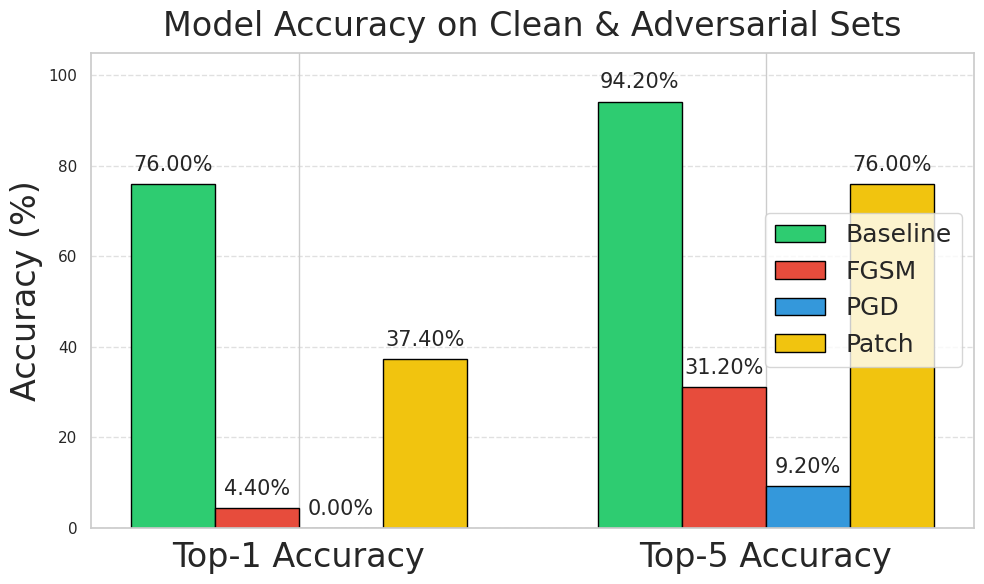

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

metrics   = ['Top‑1 Accuracy', 'Top‑5 Accuracy']
datasets  = ['Baseline', 'FGSM', 'PGD', 'Patch']
values    = [
    [baseline_top1, baseline_top5],
    [fgsm_top1,     fgsm_top5],
    [pgd_top1,      pgd_top5],
    [patch_top1,    patch_top5]
]

x = np.arange(len(metrics))           # 0, 1
width = 0.18
colors = ['#2ecc71', '#e74c3c', '#3498db', '#f1c40f']

plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")

# Draw 4 groups of columns in sequence
for i, (label, color) in enumerate(zip(datasets, colors)):
    offsets = x + (i - 1.5) * width # Center alignment
    vals    = values[i]
    plt.bar(offsets, vals, width,
            label=label, color=color, edgecolor='black')
    # Put a value on the top of the column
    for off, v in zip(offsets, vals):
        plt.text(off, v + 2, f'{v:.2f}%', ha='center', va='bottom', fontsize=15)

# Beautify the image
plt.ylabel('Accuracy (%)', fontsize=24)
plt.title('Model Accuracy on Clean & Adversarial Sets',
          fontsize=24, pad=12)
plt.xticks(x, metrics, fontsize=24)
plt.ylim(0, 105)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend(loc='best', frameon=True, fontsize=18)
plt.tight_layout()
plt.show()

Original image predicted label: acoustic_guitar
Adversarial image FGSM predicted label: face_powder
Adversarial image PGD predicted label: face_powder
Adversarial image Patch predicted label: face_powder
Original image predicted label: acoustic_guitar
Adversarial image FGSM predicted label: electric_guitar
Adversarial image PGD predicted label: electric_guitar
Adversarial image Patch predicted label: electric_guitar
Original image predicted label: acoustic_guitar
Adversarial image FGSM predicted label: stage
Adversarial image PGD predicted label: ballplayer
Adversarial image Patch predicted label: acoustic_guitar


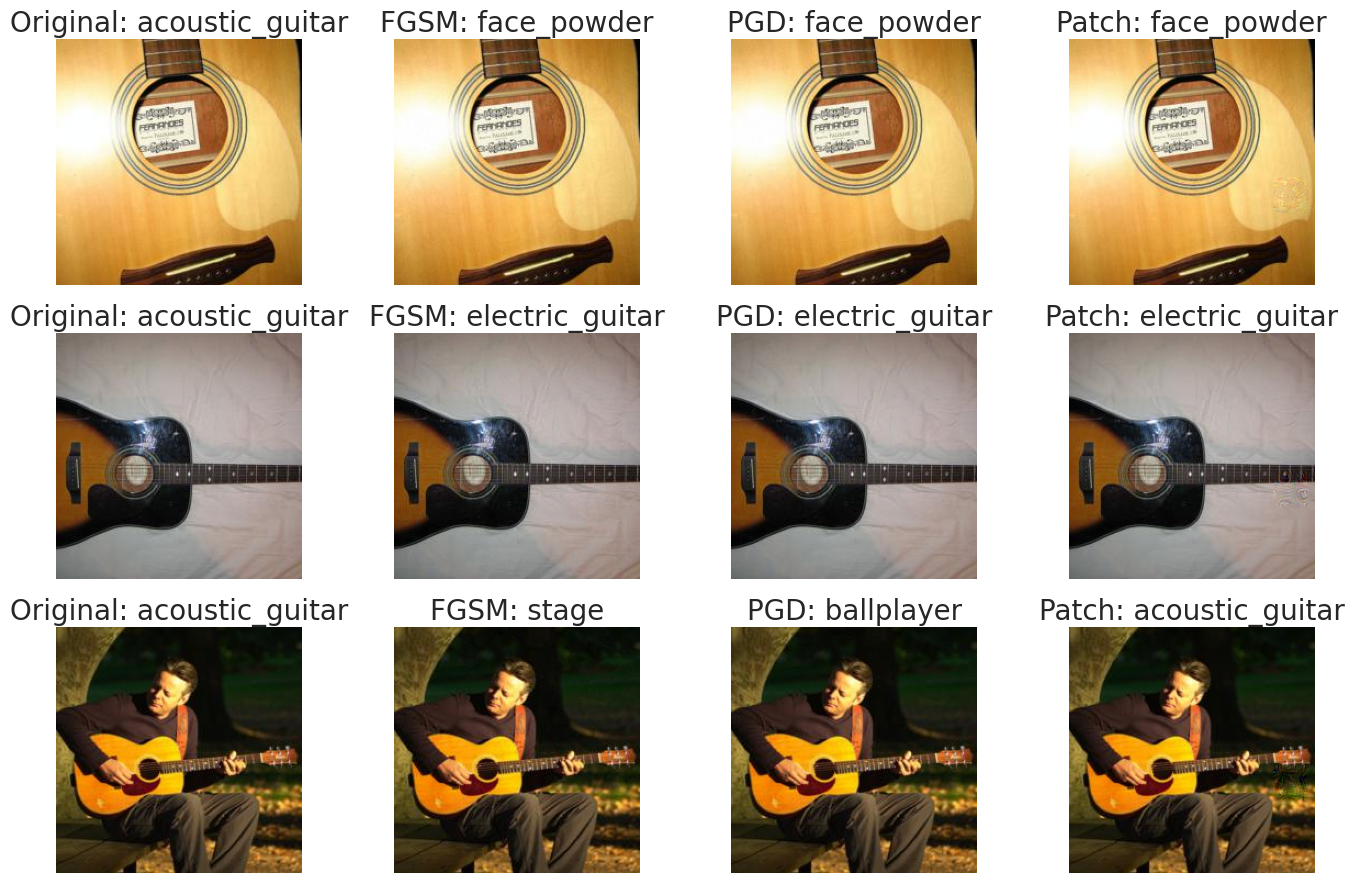

In [25]:
k = 3                              # Take the first k examples
datasets = [test_dataset, adv_dataset1, adv_dataset2, adv_dataset3]
titles   = ['Original','FGSM','PGD','Patch']
title_fontsize = 20

fig, axes = plt.subplots(k, len(datasets), figsize=(14,3*k))

model.eval()
with torch.no_grad():
    for row in range(k):
        orig_img, _ = test_dataset[row+6]
        orig_input = orig_img.unsqueeze(0).to(device)

        # Get model prediction for the original image
        orig_pred = model(orig_input).argmax(1).item()

        # Use the ImageNet mapping to find the predicted class names
        if str(orig_pred) in idx_to_synset:
            synset, label = idx_to_synset[str(orig_pred)]
            orig_label = label
        else:
            orig_label = "Unknown"
        print(f"Original image predicted label: {orig_label}")

        # Draw the original image first
        plt.sca(axes[row, 0])
        imshow(orig_img, f'Original: {orig_label}')
        plt.title(f'Original: {orig_label}', fontsize=title_fontsize)

        # Draw adversarial images
        for col, (ds, title) in enumerate(zip(datasets[1:], titles[1:]), start=1):
            adv_img, _ = ds[row+6]
            adv_input = adv_img.unsqueeze(0).to(device)

            # Get model prediction for the adversarial image
            adv_pred = model(adv_input).argmax(1).item()

            # Use the ImageNet mapping to find the predicted class names
            if str(adv_pred) in idx_to_synset:
                synset, label = idx_to_synset[str(adv_pred)]
                adv_label = label
            else:
                adv_label = "Unknown"
            print(f"Adversarial image {title} predicted label: {adv_label}")

            plt.sca(axes[row, col])
            imshow(adv_img, f'{title}: {adv_label}')
            plt.title(f'{title}: {adv_label}', fontsize=title_fontsize)

plt.tight_layout()
plt.show()
